In [923]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [924]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [925]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2081808 entries, 0 to 2081807
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 31.8 MB


# reduce to 1 million events

In [926]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion Interval -> kWh

In [927]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,27442,0.13,27.442
1,27106,0.13,27.106
2,27181,0.13,27.181
3,27580,0.13,27.580
4,27654,0.13,27.654
...,...,...,...
999995,29398,0.12,29.398
999996,29851,0.12,29.851
999997,29370,0.12,29.370
999998,29431,0.12,29.431


In [928]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [929]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [930]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26076826850000

### Calcul de la date de base = now - cumul_interval

In [931]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 6, 4, 14, 53, 38, 280066)

In [932]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [933]:
conso_data.iloc[0]


Interval     27442.000000
kWh              0.130000
sec             27.442000
Wh             131.185774
cumul(ms)    27442.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [934]:
base

datetime.datetime(2024, 6, 4, 14, 53, 38, 280066)

## créer les dates

In [935]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-06-04 14:54:05.722066
1        2024-06-04 14:54:32.828066
2        2024-06-04 14:55:00.009066
3        2024-06-04 14:55:27.589066
4        2024-06-04 14:55:55.243066
                    ...            
999995   2025-04-02 10:25:27.629066
999996   2025-04-02 10:25:57.480066
999997   2025-04-02 10:26:26.850066
999998   2025-04-02 10:26:56.281066
999999   2025-04-02 10:27:25.130066
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [936]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,27442,0.13,27.442,131.185774,27442,2024-06-04 14:54:05.722066,04/06/24
1,27106,0.13,27.106,132.811924,54548,2024-06-04 14:54:32.828066,04/06/24
2,27181,0.13,27.181,132.445458,81729,2024-06-04 14:55:00.009066,04/06/24
3,27580,0.13,27.580,130.529369,109309,2024-06-04 14:55:27.589066,04/06/24
4,27654,0.13,27.654,130.180082,136963,2024-06-04 14:55:55.243066,04/06/24
...,...,...,...,...,...,...,...
999995,29398,0.12,29.398,122.457310,26076709349,2025-04-02 10:25:27.629066,02/04/25
999996,29851,0.12,29.851,120.598975,26076739200,2025-04-02 10:25:57.480066,02/04/25
999997,29370,0.12,29.370,122.574055,26076768570,2025-04-02 10:26:26.850066,02/04/25
999998,29431,0.12,29.431,122.320003,26076798001,2025-04-02 10:26:56.281066,02/04/25


### save conso_data with dates

In [937]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [938]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
today, date, month, year


('02/04/25', 2, 4, 2025)

In [939]:
here = now.strftime('%H:%M:%S')
here

'10:27:38'

In [940]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [941]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1134 entries, 998866 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1134 non-null   int64         
 1   kWh        1134 non-null   float64       
 2   sec        1134 non-null   float64       
 3   Wh         1134 non-null   float64       
 4   cumul(ms)  1134 non-null   int64         
 5   dates      1134 non-null   datetime64[ns]
 6   days       1134 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 70.9+ KB


In [942]:
end = time.time()
print(end - start)

15.624235391616821


### grouped by days

In [943]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [944]:
data = list(df_grp['kWh'])
print(data)

[1.35, 3.487, 3.179, 2.923, 3.422, 3.168, 3.263, 3.772, 3.37, 3.333, 3.101, 2.939, 3.698, 3.262, 3.108, 3.207, 3.405, 2.952, 3.014, 3.537, 3.6, 3.497, 3.029, 2.982, 2.088, 2.082, 2.094, 2.082, 2.085, 2.08, 2.082, 2.076, 2.079, 3.573, 3.196, 3.408, 3.849, 3.509, 3.879, 3.546, 3.542, 3.728, 3.488, 3.399, 3.269, 3.476, 3.296, 3.722, 3.69, 3.55, 3.642, 3.401, 3.24, 3.23, 2.786, 3.077, 3.655, 3.769, 3.83, 3.005, 3.338, 3.356, 3.507, 3.65, 3.671, 3.478, 3.805, 3.858, 3.69, 4.44, 4.21, 3.896, 3.924, 4.01, 3.816, 3.832, 3.71, 3.286, 3.932, 3.954, 4.436, 3.767, 4.141, 3.771, 3.971, 3.782, 3.95, 3.728, 3.581, 3.5, 3.684, 3.525, 4.123, 3.705, 3.446, 3.529, 3.272, 2.401, 1.795, 1.793, 1.792, 1.796, 2.497, 1.842, 1.787, 1.791, 1.791, 1.821, 1.822, 1.814, 1.817, 1.819, 1.817, 1.816, 1.813, 1.785, 1.786, 1.785, 1.786, 1.783, 1.796, 1.789, 1.789, 1.785, 1.796, 1.803, 1.795, 1.804, 1.795, 1.785, 1.79, 1.784, 1.791, 1.797, 1.791, 1.801, 1.803, 1.795, 1.8, 1.798, 2.834, 3.994, 3.64, 3.915, 3.098, 3.647, 

In [945]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [946]:
end = time.time()
print(end - start)

15.946950197219849


### plot function by day
#### show('dd/mm/yy')

In [947]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


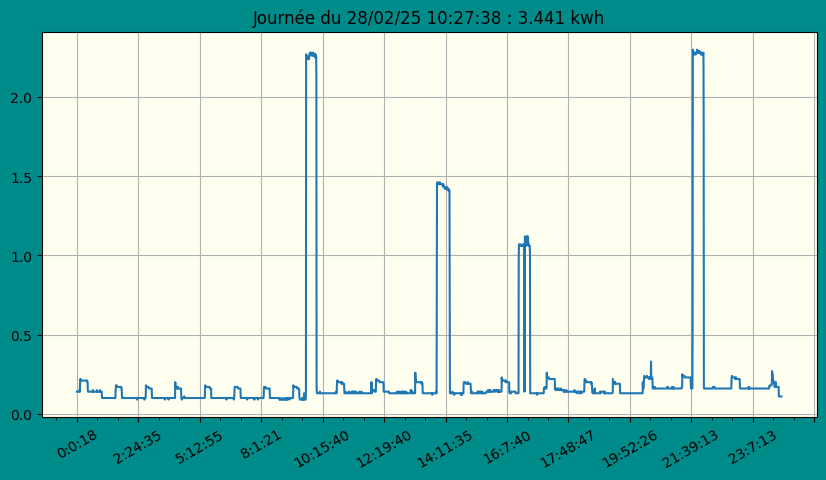

In [948]:
show('28/02/25')

In [949]:
end = time.time()
print(end - start)

16.977399349212646


### 1 kWh window in data of one day
#### df = conso_day

In [950]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998866,17594,0.20,17.594,204.615210,26039190513,2025-04-02 00:00:08.793066,02/04/25
998867,17676,0.20,17.676,203.665988,26039208189,2025-04-02 00:00:26.469066,02/04/25
998868,17308,0.21,17.308,207.996302,26039225497,2025-04-02 00:00:43.777066,02/04/25
998869,25542,0.14,25.542,140.944327,26039251039,2025-04-02 00:01:09.319066,02/04/25
998870,29502,0.12,29.502,122.025625,26039280541,2025-04-02 00:01:38.821066,02/04/25
...,...,...,...,...,...,...,...
999995,29398,0.12,29.398,122.457310,26076709349,2025-04-02 10:25:27.629066,02/04/25
999996,29851,0.12,29.851,120.598975,26076739200,2025-04-02 10:25:57.480066,02/04/25
999997,29370,0.12,29.370,122.574055,26076768570,2025-04-02 10:26:26.850066,02/04/25
999998,29431,0.12,29.431,122.320003,26076798001,2025-04-02 10:26:56.281066,02/04/25


In [951]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [952]:
df = conso_day
len(df)

1134

In [953]:
period()  # first kWh

2025-04-02 00:00:08.793066	2025-04-02 09:26:57.161066	9h 26m 48s 	1000


In [954]:
period(p=2) # second period

2025-04-02 09:26:57.161066	2025-04-02 10:27:25.130066	1h 0m 27s 	134


In [955]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.292198
dtype: float64

In [956]:
end = time.time()
print(end - start)

17.49136209487915


## mean for data grouped by days

In [957]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.30033
dtype: float64

In [958]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(1.134)

# conso by date


In [959]:
# select day
day = today

#day = '16/08/24'
day

'02/04/25'

In [960]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998866,17594,0.20,17.594,204.615210,26039190513,2025-04-02 00:00:08.793066,02/04/25
998867,17676,0.20,17.676,203.665988,26039208189,2025-04-02 00:00:26.469066,02/04/25
998868,17308,0.21,17.308,207.996302,26039225497,2025-04-02 00:00:43.777066,02/04/25
998869,25542,0.14,25.542,140.944327,26039251039,2025-04-02 00:01:09.319066,02/04/25
998870,29502,0.12,29.502,122.025625,26039280541,2025-04-02 00:01:38.821066,02/04/25
...,...,...,...,...,...,...,...
999995,29398,0.12,29.398,122.457310,26076709349,2025-04-02 10:25:27.629066,02/04/25
999996,29851,0.12,29.851,120.598975,26076739200,2025-04-02 10:25:57.480066,02/04/25
999997,29370,0.12,29.370,122.574055,26076768570,2025-04-02 10:26:26.850066,02/04/25
999998,29431,0.12,29.431,122.320003,26076798001,2025-04-02 10:26:56.281066,02/04/25


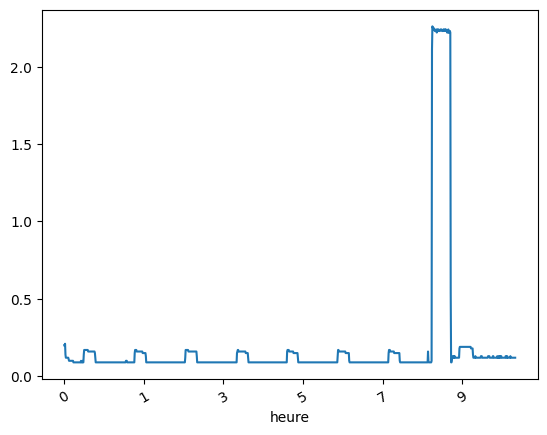

In [961]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [962]:
end = time.time()
print(end - start)

18.050769567489624


### grouped by 'heure'

In [963]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1134 entries, 998866 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1134 non-null   int64         
 1   kWh        1134 non-null   float64       
 2   sec        1134 non-null   float64       
 3   Wh         1134 non-null   float64       
 4   cumul(ms)  1134 non-null   int64         
 5   dates      1134 non-null   datetime64[ns]
 6   days       1134 non-null   object        
 7   heure      1134 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 79.7+ KB


In [964]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0,17594,0.20,17.594,204.615210,26039190513,2025-04-02 00:00:08.793066,02/04/25
0,17676,0.20,17.676,203.665988,26039208189,2025-04-02 00:00:26.469066,02/04/25
0,17308,0.21,17.308,207.996302,26039225497,2025-04-02 00:00:43.777066,02/04/25
0,25542,0.14,25.542,140.944327,26039251039,2025-04-02 00:01:09.319066,02/04/25
0,29502,0.12,29.502,122.025625,26039280541,2025-04-02 00:01:38.821066,02/04/25
...,...,...,...,...,...,...,...
10,29398,0.12,29.398,122.457310,26076709349,2025-04-02 10:25:27.629066,02/04/25
10,29851,0.12,29.851,120.598975,26076739200,2025-04-02 10:25:57.480066,02/04/25
10,29370,0.12,29.370,122.574055,26076768570,2025-04-02 10:26:26.850066,02/04/25


In [965]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [966]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     110
1     104
2      91
3     103
4     103
5     102
6     101
7      90
8     100
9     173
10     57
Name: kWh, dtype: int64

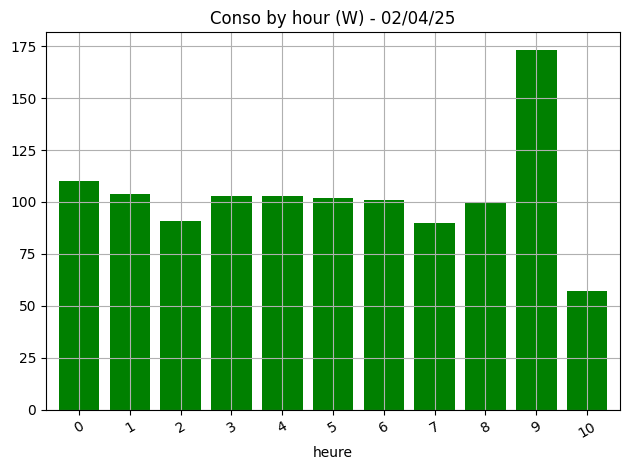

In [967]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [968]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 04/06/24 to 02/04/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     303 non-null    float64
dtypes: float64(1)
memory usage: 4.7+ KB


In [969]:
# give the periods of 1 kwh in a day
period()

2025-04-02 00:00:08.793066	2025-04-02 09:26:57.161066	9h 26m 48s 	1000


In [970]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


(Timestamp('2025-04-02 00:00:08.793066'),
 Timestamp('2025-04-02 09:27:16.039066'))

In [971]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [972]:
df_grp.mean()


kWh    3.30033
dtype: float64

In [973]:
df_grp.head()


,kWh
days,
04/06/24,1.350
05/06/24,3.487
06/06/24,3.179
07/06/24,2.923
08/06/24,3.422


In [974]:
df_grp.tail()


,kWh
days,
29/03/25,3.841
30/03/25,4.002
31/03/25,3.412
01/04/25,3.718
02/04/25,1.134


In [975]:
end = time.time()
print(end - start)

19.152080535888672


# plot les 100 derniers jours


In [976]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.65671
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

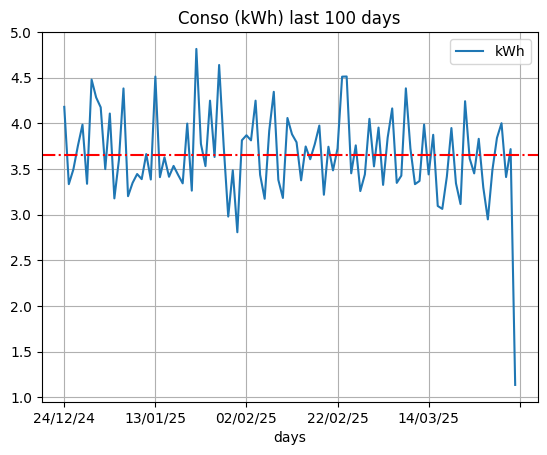

In [977]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label='moyenne')
plt.grid()
plt.title('Conso (kWh) last 100 days')


In [978]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,1.134
max,4.816


In [979]:
end = time.time()
print(end - start)

19.75864052772522


In [980]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('03/03/25', '28/03/25')

In [981]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    3.600333
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

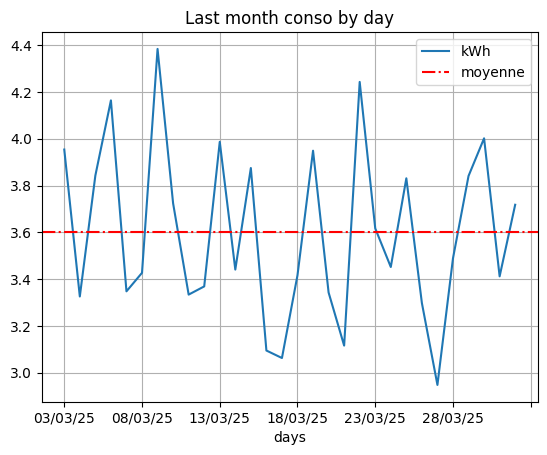

In [982]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label='moyenne')
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [983]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 09/03/25 4.384
Min : 27/03/25 2.948


# Temps de conso par tranche de 1 kWh

In [984]:

tranches = len(df)//1000
tranches+1


2

In [985]:
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p=p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


2025-04-02 00:00:08.793066	2025-04-02 09:26:57.161066	9h 26m 48s 	1000
2025-04-02 09:26:57.161066	2025-04-02 10:27:25.130066	1h 0m 27s 	134


('10:27:38', 1.134, 1134)

In [986]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1134 entries, 998866 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1134 non-null   int64         
 1   kWh        1134 non-null   float64       
 2   sec        1134 non-null   float64       
 3   Wh         1134 non-null   float64       
 4   cumul(ms)  1134 non-null   int64         
 5   dates      1134 non-null   datetime64[ns]
 6   days       1134 non-null   object        
 7   heure      1134 non-null   object        
 8   hours      1134 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 88.6+ KB


In [987]:
conso_hours['heure'], conso_hours['hours']

(998866     0
 998867     0
 998868     0
 998869     0
 998870     0
           ..
 999995    10
 999996    10
 999997    10
 999998    10
 999999    10
 Name: heure, Length: 1134, dtype: object,
 998866    00
 998867    00
 998868    00
 998869    00
 998870    00
           ..
 999995    10
 999996    10
 999997    10
 999998    10
 999999    10
 Name: hours, Length: 1134, dtype: object)

In [988]:
end = time.time()
print(end - start)

20.543399333953857


# select number of days to display


In [989]:
span = 30
#df_grp.tail(span)

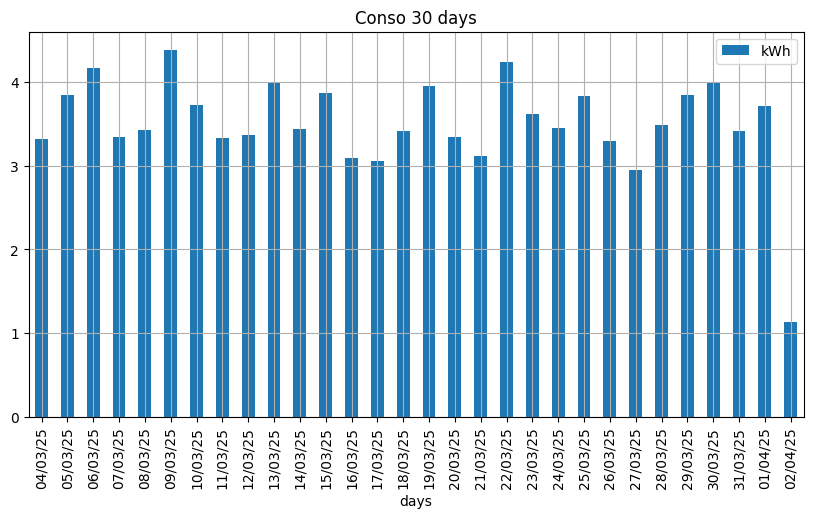

In [990]:

# Plot the figure without labels
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight') 
plt.title(f'Conso {span} days')
plt.xticks(rotation=90);


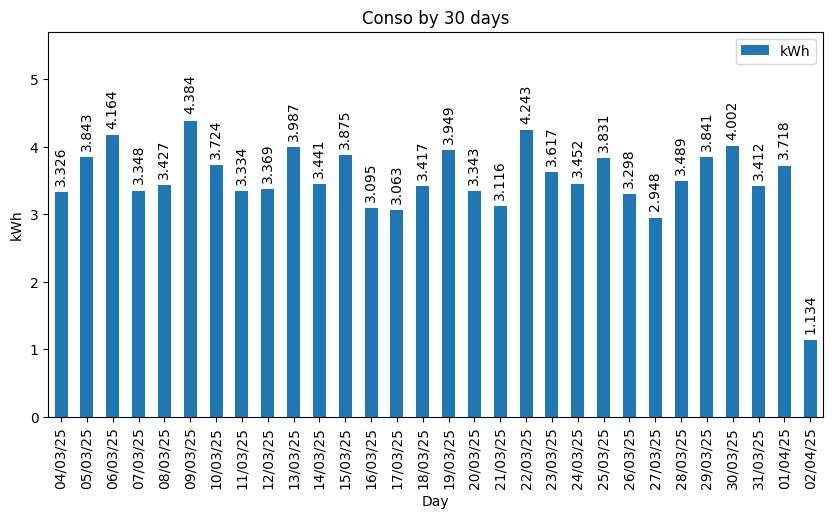

In [991]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
ax.set_title(f"Conso by {span} days")
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [992]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
04/03/25    3.326
05/03/25    3.843
06/03/25    4.164
07/03/25    3.348
08/03/25    3.427
09/03/25    4.384
10/03/25    3.724
11/03/25    3.334
12/03/25    3.369
13/03/25    3.987
14/03/25    3.441
15/03/25    3.875
16/03/25    3.095
17/03/25    3.063
18/03/25    3.417
19/03/25    3.949
20/03/25    3.343
21/03/25    3.116
22/03/25    4.243
23/03/25    3.617
24/03/25    3.452
25/03/25    3.831
26/03/25    3.298
27/03/25    2.948
28/03/25    3.489
29/03/25    3.841
30/03/25    4.002
31/03/25    3.412
01/04/25    3.718
02/04/25    1.134
Name: kWh, dtype: float64

In [993]:
x_labels=df_grp.tail(span).index
x_labels

Index(['04/03/25', '05/03/25', '06/03/25', '07/03/25', '08/03/25', '09/03/25',
       '10/03/25', '11/03/25', '12/03/25', '13/03/25', '14/03/25', '15/03/25',
       '16/03/25', '17/03/25', '18/03/25', '19/03/25', '20/03/25', '21/03/25',
       '22/03/25', '23/03/25', '24/03/25', '25/03/25', '26/03/25', '27/03/25',
       '28/03/25', '29/03/25', '30/03/25', '31/03/25', '01/04/25', '02/04/25'],
      dtype='object', name='days')

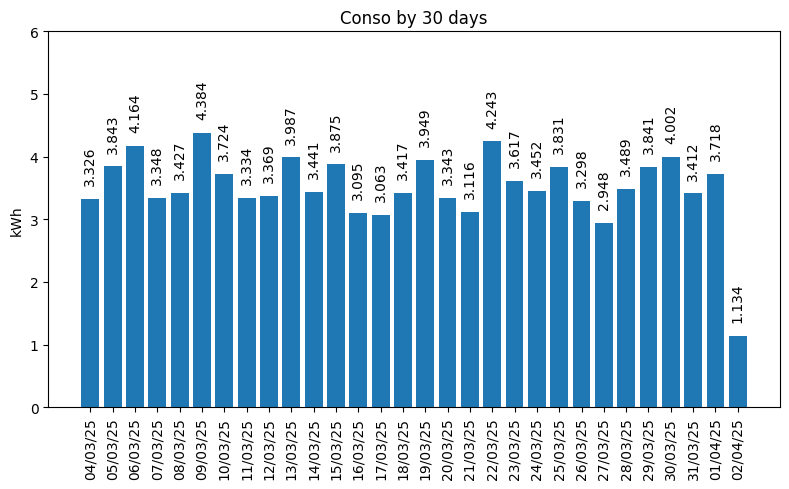

In [994]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
ax.set(ylabel='kWh', title=f'Conso by {span} days', ylim=(0, 6))
plt.xticks(rotation=90);


In [995]:
end = time.time()
print(end - start)

23.71970224380493


In [996]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

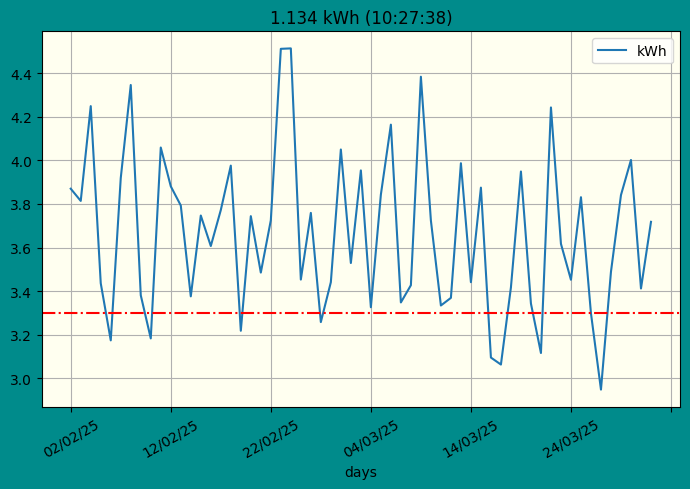

In [997]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")


df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=np.nanmean(df_grp),c='red', ls='-.')
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

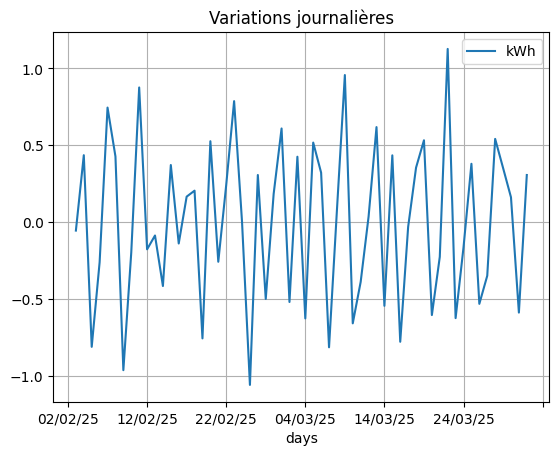

In [998]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [999]:
end = time.time()
print(end - start)

24.781556844711304


# Data from 21/08/23

In [1000]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,27442,0.13,27.442,131.185774,27442,2024-06-04 14:54:05.722066,04/06/24,14,2024-06,04
1,27106,0.13,27.106,132.811924,54548,2024-06-04 14:54:32.828066,04/06/24,14,2024-06,04
2,27181,0.13,27.181,132.445458,81729,2024-06-04 14:55:00.009066,04/06/24,14,2024-06,04
3,27580,0.13,27.580,130.529369,109309,2024-06-04 14:55:27.589066,04/06/24,14,2024-06,04
4,27654,0.13,27.654,130.180082,136963,2024-06-04 14:55:55.243066,04/06/24,14,2024-06,04
...,...,...,...,...,...,...,...,...,...,...
999995,29398,0.12,29.398,122.457310,26076709349,2025-04-02 10:25:27.629066,02/04/25,10,2025-04,02
999996,29851,0.12,29.851,120.598975,26076739200,2025-04-02 10:25:57.480066,02/04/25,10,2025-04,02
999997,29370,0.12,29.370,122.574055,26076768570,2025-04-02 10:26:26.850066,02/04/25,10,2025-04,02
999998,29431,0.12,29.431,122.320003,26076798001,2025-04-02 10:26:56.281066,02/04/25,10,2025-04,02


In [1001]:
end = time.time()
print(end - start)

59.64235758781433


In [1002]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04'])

# define month to show

In [1003]:
month=conso_grouped_by_month.get_group('2025-02')

In [1004]:
conso_grouped_by_month_day = month.groupby(['day'], sort=False)

<Axes: xlabel='day'>

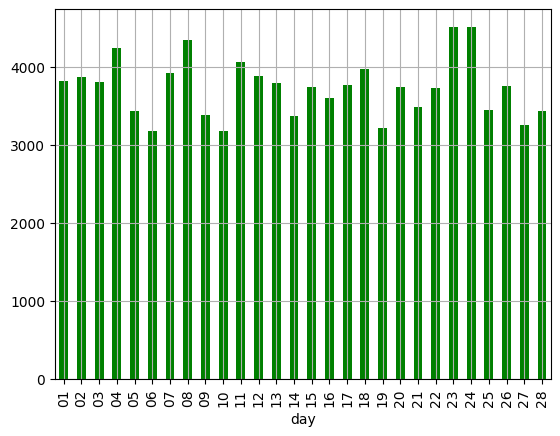

In [1005]:
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)

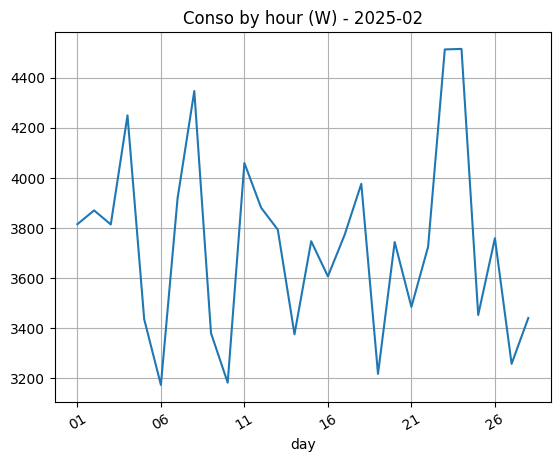

In [1006]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
plt.title('Conso by hour (W) - '+month.iloc[0]['months'])
plt.xticks(rotation=30);


In [1007]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

In [1008]:
conso_grouped_by_month_day.count()

,hours,months,kWh
day,,,
01,3815,3815,3815
02,3870,3870,3870
03,3814,3814,3814
04,4249,4249,4249
05,3436,3436,3436
06,3174,3174,3174
07,3919,3919,3919
08,4346,4346,4346
09,3381,3381,3381


In [1009]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [1010]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [1011]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-06,82862,82862,82862
2024-07,99404,99404,99404
2024-08,117325,117325,117325
2024-09,69750,69750,69750
2024-10,73556,73556,73556
2024-11,108500,108500,108500
2024-12,113787,113787,113787
2025-01,113586,113586,113586
2025-02,104507,104507,104507


In [1012]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [1013]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [1014]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
04/06/24,1350
05/06/24,3487
06/06/24,3179
07/06/24,2923
08/06/24,3422
...,...
29/03/25,3841
30/03/25,4002
31/03/25,3412


In [1015]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,27442,0.13,27.442,131.185774,27442,2024-06-04 14:54:05.722066,04/06/24,14,2024-06,04
1,27106,0.13,27.106,132.811924,54548,2024-06-04 14:54:32.828066,04/06/24,14,2024-06,04
2,27181,0.13,27.181,132.445458,81729,2024-06-04 14:55:00.009066,04/06/24,14,2024-06,04
3,27580,0.13,27.580,130.529369,109309,2024-06-04 14:55:27.589066,04/06/24,14,2024-06,04
4,27654,0.13,27.654,130.180082,136963,2024-06-04 14:55:55.243066,04/06/24,14,2024-06,04
...,...,...,...,...,...,...,...,...,...,...
999995,29398,0.12,29.398,122.457310,26076709349,2025-04-02 10:25:27.629066,02/04/25,10,2025-04,02
999996,29851,0.12,29.851,120.598975,26076739200,2025-04-02 10:25:57.480066,02/04/25,10,2025-04,02
999997,29370,0.12,29.370,122.574055,26076768570,2025-04-02 10:26:26.850066,02/04/25,10,2025-04,02
999998,29431,0.12,29.431,122.320003,26076798001,2025-04-02 10:26:56.281066,02/04/25,10,2025-04,02


In [1016]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
04/06/24 14    0       04/06/24    14  0.13
               1       04/06/24    14  0.13
               2       04/06/24    14  0.13
               3       04/06/24    14  0.13
               4       04/06/24    14  0.13
...                         ...   ...   ...
02/04/25 10    999995  02/04/25    10  0.12
               999996  02/04/25    10  0.12
               999997  02/04/25    10  0.12
               999998  02/04/25    10  0.12
               999999  02/04/25    10  0.12

[1000000 rows x 3 columns]

In [1017]:
groupallbyday.indices.keys()

dict_keys(['04/06/24', '05/06/24', '06/06/24', '07/06/24', '08/06/24', '09/06/24', '10/06/24', '11/06/24', '12/06/24', '13/06/24', '14/06/24', '15/06/24', '16/06/24', '17/06/24', '18/06/24', '19/06/24', '20/06/24', '21/06/24', '22/06/24', '23/06/24', '24/06/24', '25/06/24', '26/06/24', '27/06/24', '28/06/24', '29/06/24', '30/06/24', '01/07/24', '02/07/24', '03/07/24', '04/07/24', '05/07/24', '06/07/24', '07/07/24', '08/07/24', '09/07/24', '10/07/24', '11/07/24', '12/07/24', '13/07/24', '14/07/24', '15/07/24', '16/07/24', '17/07/24', '18/07/24', '19/07/24', '20/07/24', '21/07/24', '22/07/24', '23/07/24', '24/07/24', '25/07/24', '26/07/24', '27/07/24', '28/07/24', '29/07/24', '30/07/24', '31/07/24', '01/08/24', '02/08/24', '03/08/24', '04/08/24', '05/08/24', '06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/08/24', '14/08/24', '15/08/24', '16/08/24', '17/08/24', '18/08/24', '19/08/24', '20/08/24', '21/08/24', '22/08/24', '23/08/24', '24/08/24', '25/0

In [1018]:
groupallbydayhours.indices.keys()

dict_keys([('04/06/24', '14'), ('04/06/24', '15'), ('04/06/24', '16'), ('04/06/24', '17'), ('04/06/24', '18'), ('04/06/24', '19'), ('04/06/24', '20'), ('04/06/24', '21'), ('04/06/24', '22'), ('04/06/24', '23'), ('05/06/24', '14'), ('05/06/24', '15'), ('05/06/24', '16'), ('05/06/24', '17'), ('05/06/24', '18'), ('05/06/24', '19'), ('05/06/24', '20'), ('05/06/24', '21'), ('05/06/24', '22'), ('05/06/24', '23'), ('05/06/24', '00'), ('05/06/24', '01'), ('05/06/24', '02'), ('05/06/24', '03'), ('05/06/24', '04'), ('05/06/24', '05'), ('05/06/24', '06'), ('05/06/24', '07'), ('05/06/24', '08'), ('05/06/24', '09'), ('05/06/24', '10'), ('05/06/24', '11'), ('05/06/24', '12'), ('05/06/24', '13'), ('06/06/24', '14'), ('06/06/24', '15'), ('06/06/24', '16'), ('06/06/24', '17'), ('06/06/24', '18'), ('06/06/24', '19'), ('06/06/24', '20'), ('06/06/24', '21'), ('06/06/24', '22'), ('06/06/24', '23'), ('06/06/24', '00'), ('06/06/24', '01'), ('06/06/24', '02'), ('06/06/24', '03'), ('06/06/24', '04'), ('06/06/2

In [1019]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
04/06/24,1350,1350
05/06/24,3487,3487
06/06/24,3179,3179
07/06/24,2923,2923
08/06/24,3422,3422
...,...,...
29/03/25,3841,3841
30/03/25,4002,4002
31/03/25,3412,3412


In [1020]:
grp_by_day['kWh'].cumsum()

days
04/06/24       1350
05/06/24       4837
06/06/24       8016
07/06/24      10939
08/06/24      14361
             ...   
29/03/25     987734
30/03/25     991736
31/03/25     995148
01/04/25     998866
02/04/25    1000000
Name: kWh, Length: 303, dtype: int64

In [1021]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
04/06/24 14      14
         15     240
         16     144
         17     139
         18     111
...             ...
02/04/25 06     101
         07      90
         08     100
         09     173
         10      57

[7245 rows x 1 columns]

In [1022]:
grp_by_dayhours['kWh'].cumsum()

days      hours
04/06/24  14            14
          15           254
          16           398
          17           537
          18           648
                    ...   
02/04/25  06        999580
          07        999670
          08        999770
          09        999943
          10       1000000
Name: kWh, Length: 7245, dtype: int64

In [1023]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
04/06/24 14      14      14    NaN
         15     240     254  226.0
         16     144     398  -96.0
         17     139     537   -5.0
         18     111     648  -28.0
...             ...     ...    ...
02/04/25 06     101     714   -1.0
         07      90     804  -11.0
         08     100     904   10.0
         09     173    1077   73.0
         10      57    1134 -116.0

[7245 rows x 3 columns]

In [1024]:
today, grp_by_dayhours.loc[today]

('02/04/25',
        kWh  cumsum   diff
 hours                    
 00     110     110    NaN
 01     104     214   -6.0
 02      91     305  -13.0
 03     103     408   12.0
 04     103     511    0.0
 05     102     613   -1.0
 06     101     714   -1.0
 07      90     804  -11.0
 08     100     904   10.0
 09     173    1077   73.0
 10      57    1134 -116.0)

Text(0.5, 1.0, 'Cumul journalier')

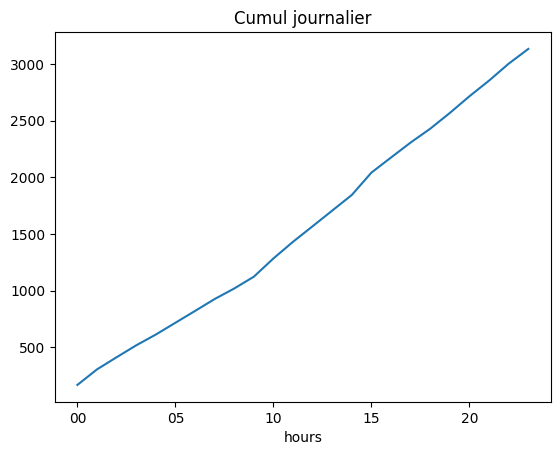

In [1025]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

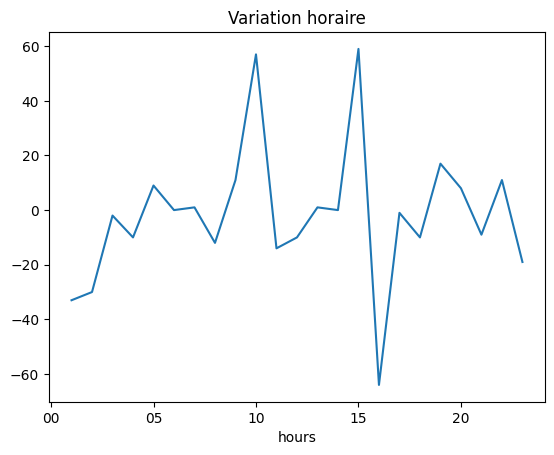

In [1026]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [1027]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

303

In [1028]:
df_grp.tail(n)['kWh'].describe()


count    303.000000
mean       3.300330
std        0.764937
min        1.134000
25%        3.124000
50%        3.476000
75%        3.779000
max        4.837000
Name: kWh, dtype: float64

In [1029]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [1030]:
n, np.nanmean(df_grp.tail(n))

(303, np.float64(3.3003300330033003))

Text(0.5, 1.0, '303 days')

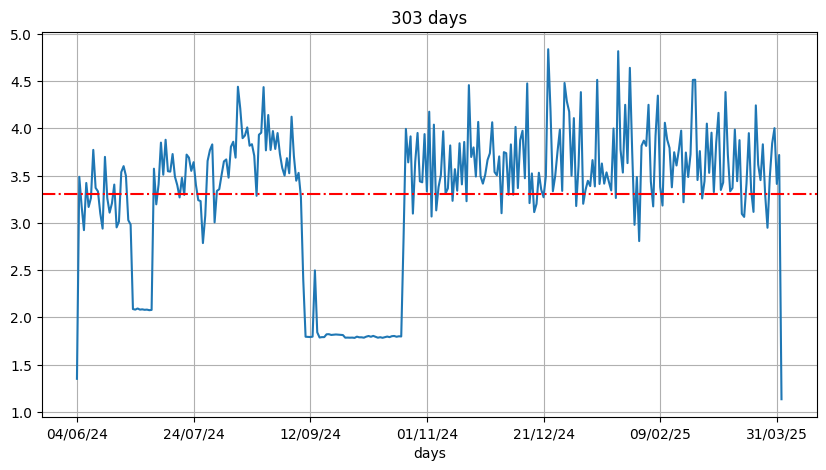

In [1031]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

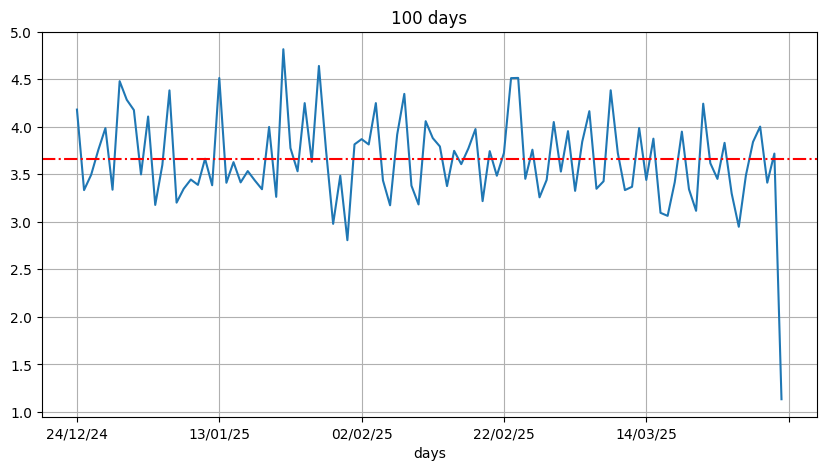

In [1032]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

In [1033]:
np.nanmean(df_grp.tail(span))

np.float64(3.6567100000000003)

In [1034]:
df_grp['kWh']

days
04/06/24    1.350
05/06/24    3.487
06/06/24    3.179
07/06/24    2.923
08/06/24    3.422
            ...  
29/03/25    3.841
30/03/25    4.002
31/03/25    3.412
01/04/25    3.718
02/04/25    1.134
Name: kWh, Length: 303, dtype: float64

In [1035]:
df_grp.describe()

,kWh
count,303.000000
mean,3.300330
std,0.764937
min,1.134000
25%,3.124000
50%,3.476000
75%,3.779000
max,4.837000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

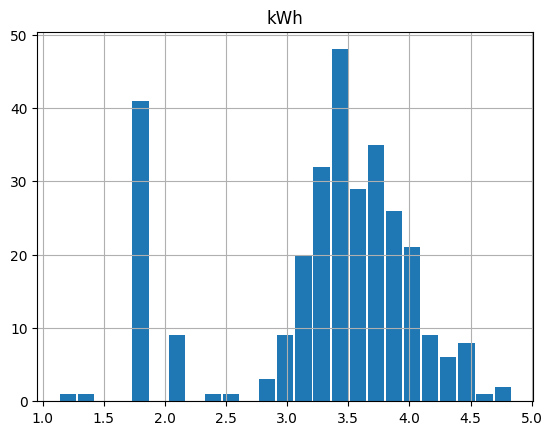

In [1036]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [1037]:
df_grp.tail(span)['kWh']

days
24/12/24    4.181
25/12/24    3.334
26/12/24    3.496
27/12/24    3.756
28/12/24    3.986
            ...  
29/03/25    3.841
30/03/25    4.002
31/03/25    3.412
01/04/25    3.718
02/04/25    1.134
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [1038]:
day

'02/04/25'

In [1039]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,110,110,NaN
01,104,214,-6.0
02,91,305,-13.0
03,103,408,12.0
04,103,511,0.0
05,102,613,-1.0
06,101,714,-1.0
07,90,804,-11.0
08,100,904,10.0


In [1040]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


11

In [1041]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 12)

In [1042]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [1043]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [1044]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
Name: days, dtype: float64

In [1045]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [1046]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, 00 to 10
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     11 non-null     int64  
 1   cumsum  11 non-null     int64  
 2   diff    10 non-null     float64
 3   days    11 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 440.0+ bytes


In [1047]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
Name: days, dtype: float64

In [1048]:
day

'02/04/25'

In [1049]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,110,110,NaN,1.0
01,104,214,-6.0,2.0
02,91,305,-13.0,3.0
03,103,408,12.0,4.0
04,103,511,0.0,5.0
05,102,613,-1.0,6.0
06,101,714,-1.0,7.0
07,90,804,-11.0,8.0
08,100,904,10.0,9.0


Text(0.5, 1.0, '02/04/25')

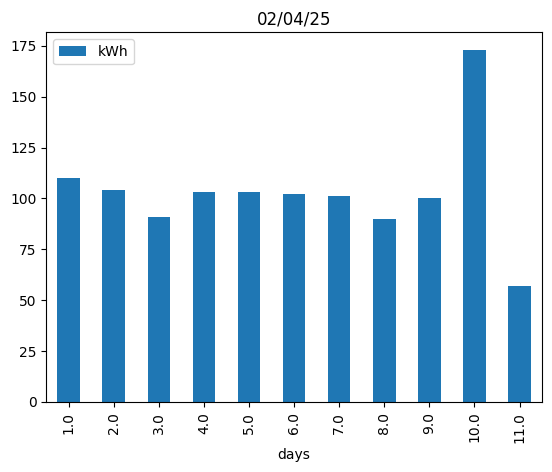

In [1050]:
grp_by_dayhours.loc[day][['days','kWh']].plot.bar(x='days')
plt.title(f'{day}')

In [1051]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10'], dtype='object', name='hours')

# Conso du jour


In [1052]:

grp_by_dayhours.count()

kWh       7245
cumsum    7245
diff      6942
days        11
dtype: int64

In [1053]:
day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh

hours
00     167
01     136
02     134
03     135
04     114
05     109
06     110
07     108
08     109
09     109
10     109
11     100
12     167
13     142
14     139
15     133
16    1013
17     530
18     136
19     210
20     168
21     237
22     243
23     279
Name: kWh, dtype: int64

In [1054]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

In [1055]:
df_grp.tail(7)['kWh']

days
27/03/25    2.948
28/03/25    3.489
29/03/25    3.841
30/03/25    4.002
31/03/25    3.412
01/04/25    3.718
02/04/25    1.134
Name: kWh, dtype: float64

Total= 365.671 , Moyenne= 3.6567100000000003


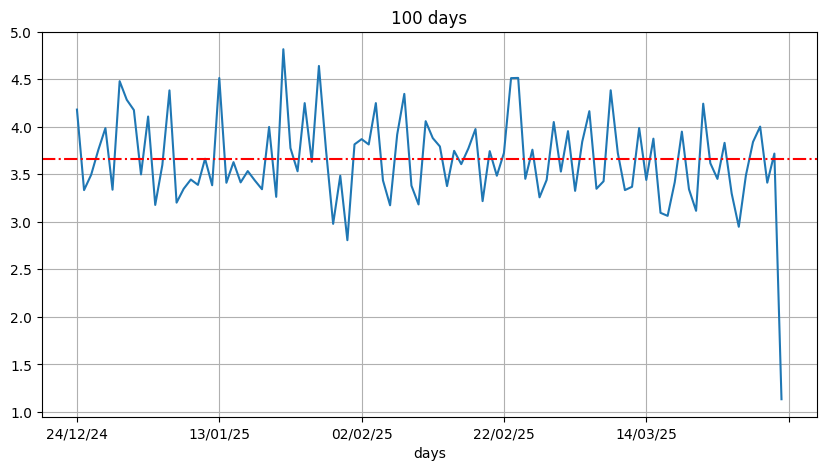

In [1056]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [1057]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

71.73072791099548


# Today

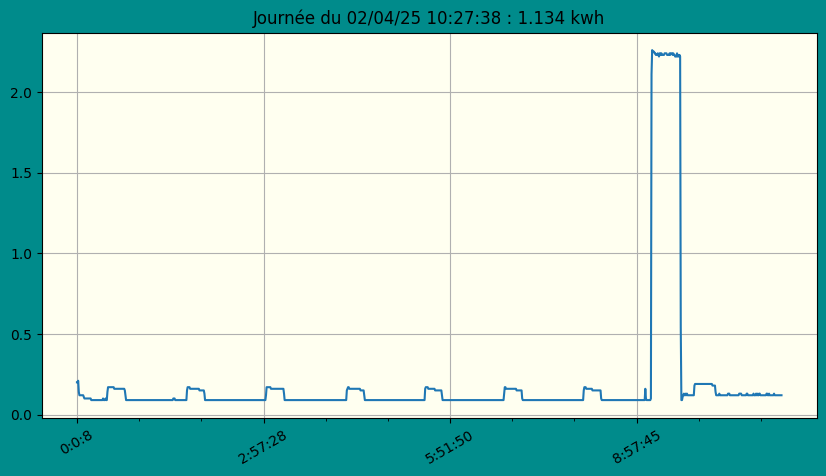

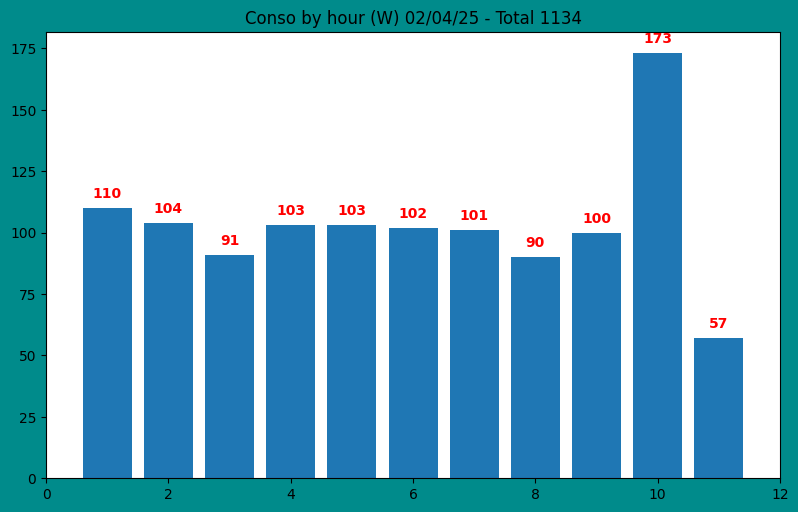

In [1058]:
show(today,bgcolor='ivory')
conso_by_hour(today)

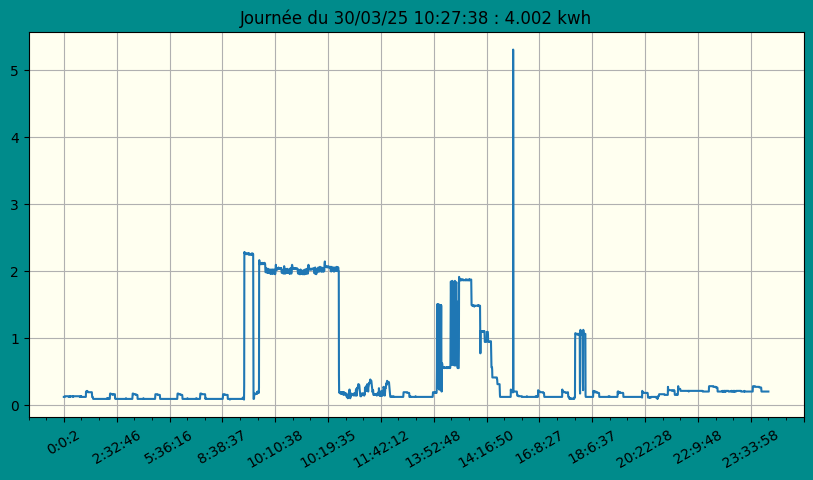

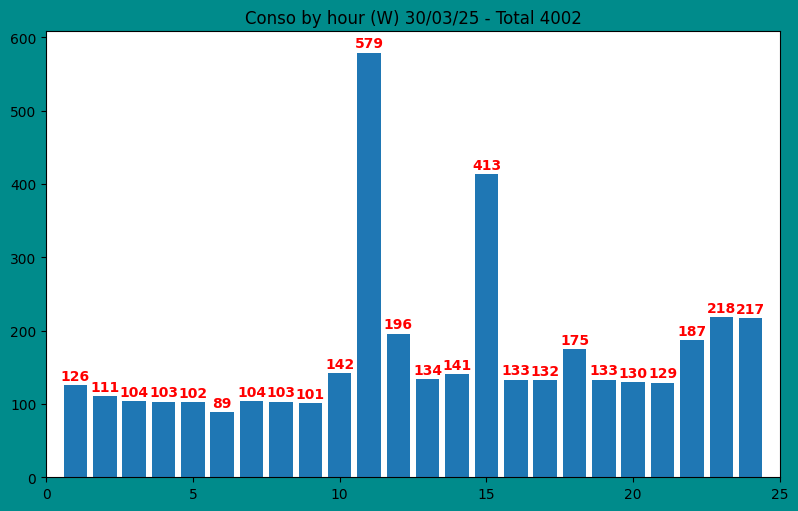

In [1059]:
day = '30/03/25'
day, show(day,bgcolor='ivory')
conso_by_hour(day)

23/12/24


(None, 4837)

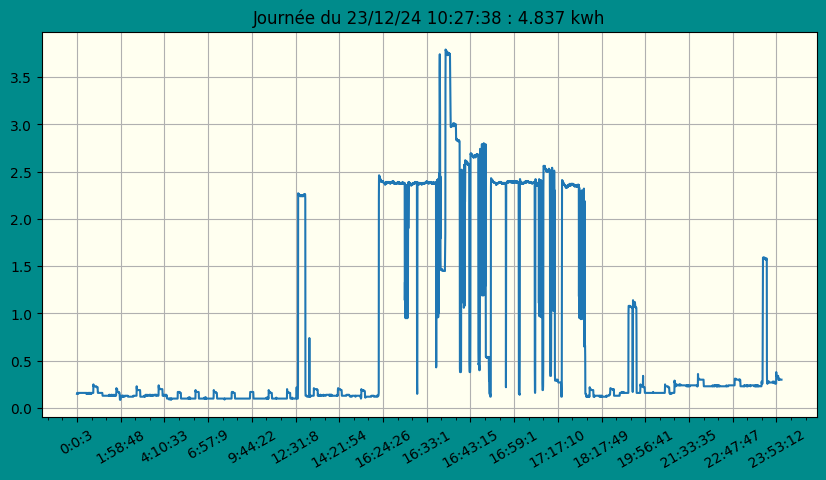

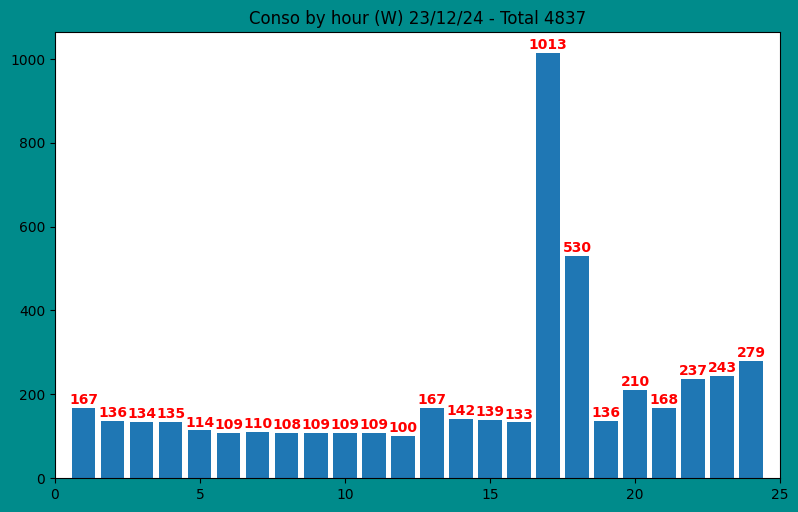

In [1060]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

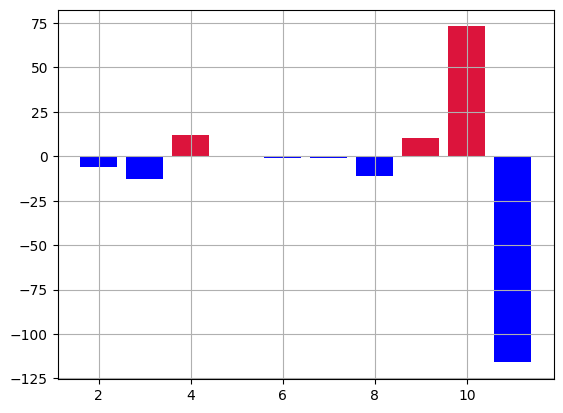

In [1061]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

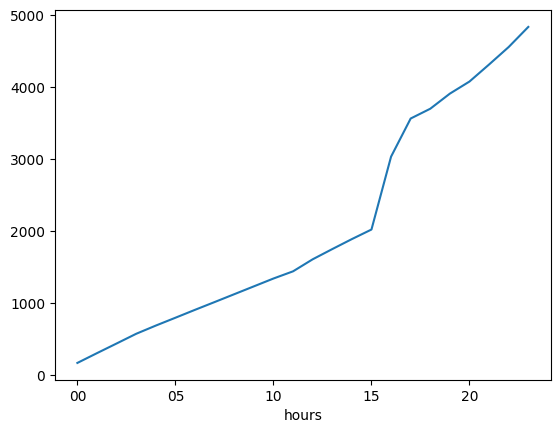

In [1062]:
data.cumsum().plot()


<Axes: xlabel='hours'>

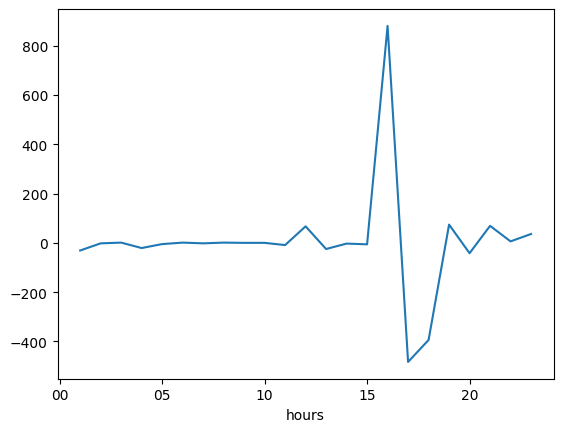

In [1063]:
# evolution par heure
data.diff().plot()

In [1064]:
data.diff().describe()

count     23.000000
mean       4.869565
std      231.829739
min     -483.000000
25%      -15.000000
50%       -2.000000
75%        3.500000
max      880.000000
Name: kWh, dtype: float64

<Axes: >

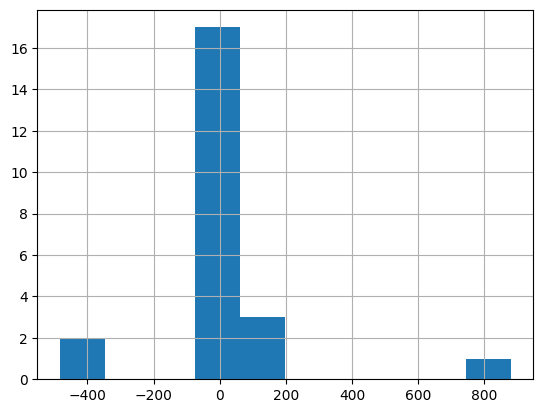

In [1065]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [1066]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'table-indicateurs-open-data-france-2023-06-30-17h59.csv',
 'primes12million.pkl',
 'espace_de_phase.ipynb',
 'ipinfo_test.ipynb',
 'enigma_settings.json',
 '__pycache__',
 'test_c

# list store files csv


In [1067]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('23/12/24', None)

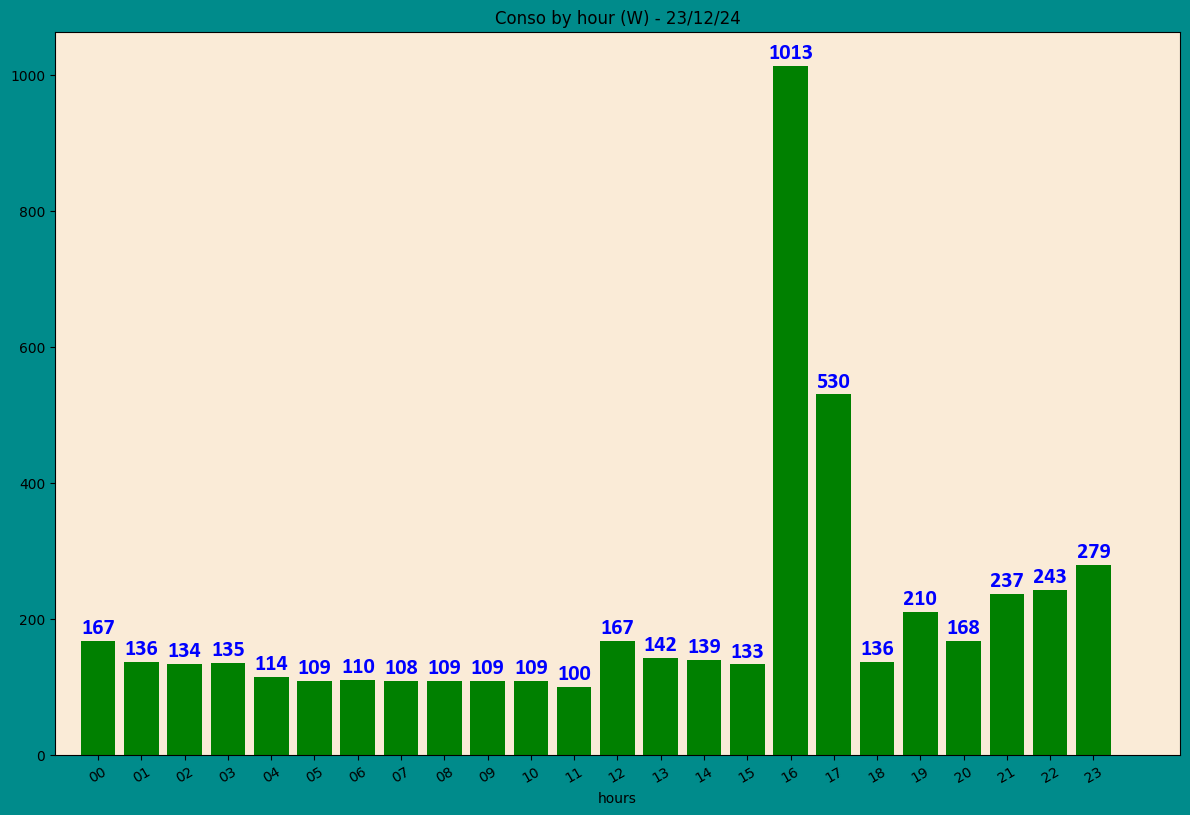

In [1068]:
day,conso_byhour(day)

In [1069]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


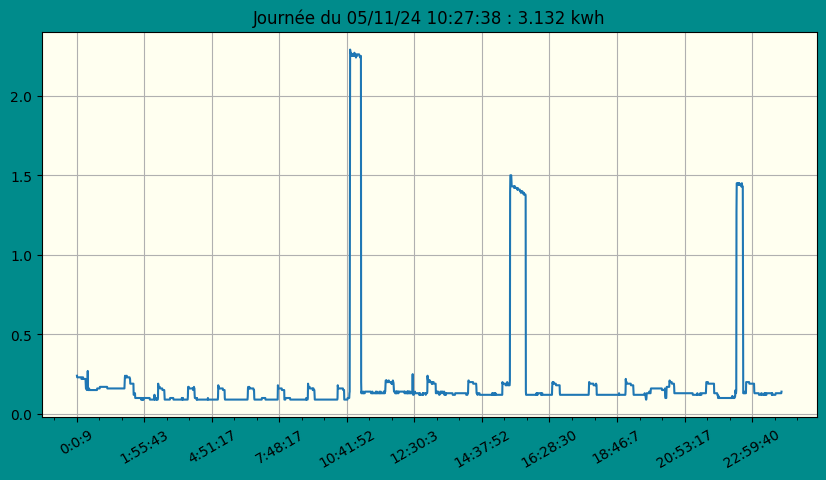

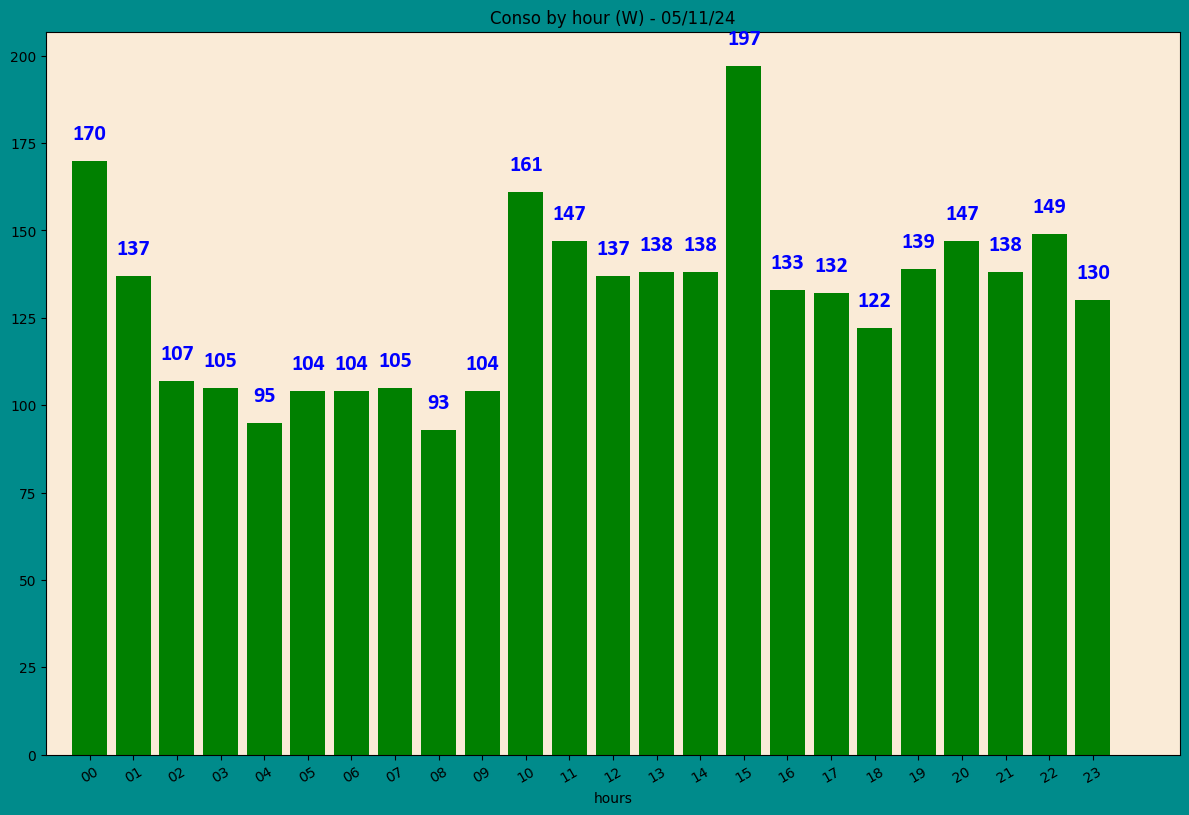

In [1070]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [1071]:
month

,day,hours,months,kWh
778770,01,00,2025-02,0.14
778771,01,00,2025-02,0.14
778772,01,00,2025-02,0.14
778773,01,00,2025-02,0.14
778774,01,00,2025-02,0.15
...,...,...,...,...
883272,28,23,2025-02,0.11
883273,28,23,2025-02,0.11
883274,28,23,2025-02,0.11
883275,28,23,2025-02,0.11


In [1072]:
month.describe()


,kWh
count,104507.000000
mean,0.334550
std,0.555034
min,0.090000
25%,0.120000
50%,0.140000
75%,0.190000
max,3.650000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

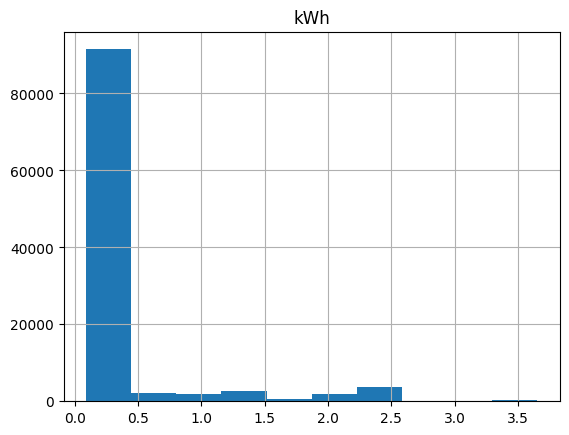

In [1073]:
month.hist()

<Axes: >

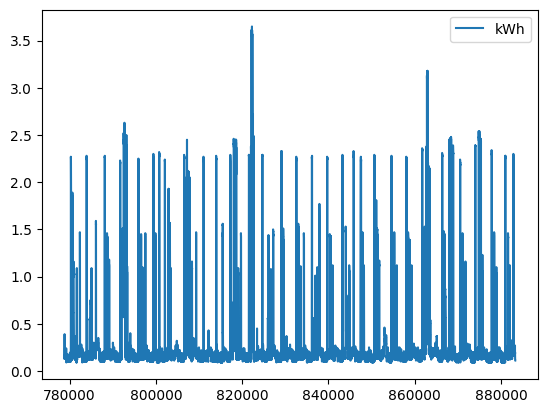

In [1074]:
month.plot()

In [1075]:
# index with max conso in this month
month.idxmax().kWh

np.int64(822271)

In [1076]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       879836
hours     782412
months    778770
kWh       822271
dtype: int64

In [1077]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [1078]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
04/06/24 14      14      14    NaN   NaN
         15     240     254  226.0   NaN
         16     144     398  -96.0   NaN
         17     139     537   -5.0   NaN
         18     111     648  -28.0   NaN
...             ...     ...    ...   ...
02/04/25 06     101     714   -1.0   7.0
         07      90     804  -11.0   8.0
         08     100     904   10.0   9.0
         09     173    1077   73.0  10.0
         10      57    1134 -116.0  11.0

[7245 rows x 4 columns]

In [1079]:
month

,day,hours,months,kWh
778770,01,00,2025-02,0.14
778771,01,00,2025-02,0.14
778772,01,00,2025-02,0.14
778773,01,00,2025-02,0.14
778774,01,00,2025-02,0.15
...,...,...,...,...
883272,28,23,2025-02,0.11
883273,28,23,2025-02,0.11
883274,28,23,2025-02,0.11
883275,28,23,2025-02,0.11


In [1080]:
month.idxmax()


day       879836
hours     782412
months    778770
kWh       822271
dtype: int64

In [1081]:
month.loc[month.idxmax().kWh]


day            12
hours          14
months    2025-02
kWh          3.65
Name: 822271, dtype: object

In [1082]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       145
          01       114
          02       112
          03        97
          04       111
          05       112
          06       110
          07        97
          08       110
          09       110
          10       191
          11       133
          12       149
          13       144
          14       200
          15       139
          16       192
          17       161
          18       148
          19       142
          20       165
          21       225
          22       174
          23       160
Name: kWh, dtype: int64

In [1083]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'21'

<Axes: xlabel='days,hours'>

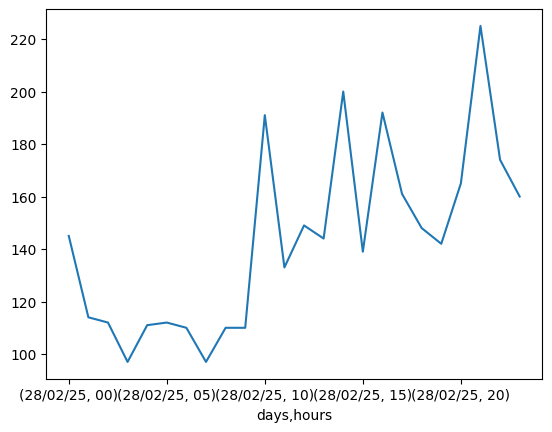

In [1084]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [1085]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [1086]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [1087]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [1088]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB